In [7]:
import requests, json
import pandas as pd
import numpy as np
from datetime import date, timedelta
from path import Path

# Read in data
file_path = Path('../Resources/carspaces_data.csv')
df_res = pd.read_csv(file_path, parse_dates=True, index_col='Timestamp')
df_res = df_res.drop('Unnamed: 0',axis=1)
df_res.head()


,Available
Timestamp,
2022-03-11 00:00:46,148
2022-03-11 00:10:47,148
2022-03-11 00:20:49,148
2022-03-11 00:30:51,148
2022-03-11 00:40:52,148


In [8]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Define the window size
window_size = 280

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_res, window_size, feature_column, target_column)

# Print a few sample values from X and y
#print (f"X sample values:\n{X[:3]} \n")
#print (f"y sample values:\n{y[:3]}")

In [10]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [11]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train

scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train.shape} \n")
print (f"X_test sample values:\n{X_test.shape}")

X_train sample values:
(11165, 280, 1) 

X_test sample values:
(4786, 280, 1)


In [13]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 64
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

2022-04-20 21:53:13.654379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-20 21:53:13.770536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-04-20 21:53:13.770557: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-20 21:53:13.772554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [15]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 280, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 280, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 280, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 280, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [16]:
# Train the model
prediction = model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=40, verbose=1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
280/280 [==============================] - 127s 437ms/step - loss: 0.0163
Epoch 2/10
280/280 [==============================] - 138s 492ms/step - loss: 0.0054
Epoch 3/10
280/280 [==============================] - 130s 465ms/step - loss: 0.0158
Epoch 4/10
280/280 [==============================] - 109s 388ms/step - loss: 0.0060
Epoch 5/10
280/280 [==================

In [21]:
# Evaluate the model: 0.034360241144895554
model.evaluate(X_test, y_test, verbose=0)

0.001344458432868123

In [22]:
# save model and architecture to single file
model.save("model_20042022.h5")
#print("Saved model to disk")

# Make predictions using the testing data X_test
predicted = model.predict(X_test)

# Recover the original prices instead of the scaled version
predicted_carspaces = scaler.inverse_transform(predicted)
real_spaces = scaler.inverse_transform(y_test.reshape(-1, 1))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<AxesSubplot:title={'center':'Actual Vs. Predicted Car Spaces'}, xlabel='Timestamp'>

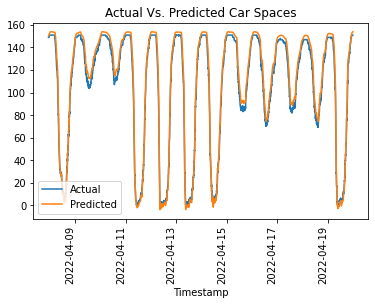

In [23]:
# Create a DataFrame of Real and Predicted values
carspaces = pd.DataFrame({
    "Actual": real_spaces.ravel(),
    "Predicted": predicted_carspaces.ravel()
}, index = df_res.index[-len(real_spaces): ]) 

# SPlot the predictions
carspaces.plot(title="Actual Vs. Predicted Car Spaces",rot=90)

<AxesSubplot:title={'center':'Actual Vs. Predicted Car Spaces'}, xlabel='Timestamp'>

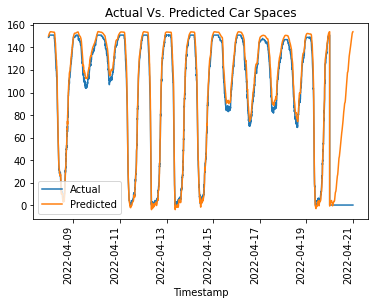

In [24]:
# 288 is approximately number of data points in a day
forecast = model.predict(X_test[-288:])
forecast_carspaces = scaler.inverse_transform(forecast)

forecast_period = pd.date_range(df_res.index[-1], periods=288, freq='5min').tolist()

df_forecast = pd.DataFrame({'Timestamp':np.array(forecast_period), 'Predicted':forecast_carspaces.flatten()})
df_forecast.set_index(df_forecast['Timestamp'], inplace=True)
df_forecast =  df_forecast.drop(columns='Timestamp')

carspaces = pd.concat([carspaces,df_forecast])
carspaces['Actual'] = carspaces['Actual'].fillna(0)
carspaces.plot(title="Actual Vs. Predicted Car Spaces",rot=90)

In [25]:
carspaces.to_csv('../Resources/available_spaces_forecast_18042022.csv')